# Assignment 2: Training Neural Networks

We will use TensorFlow and Keras to train a neural network for a regression task on
the California Housing Dataset 1 . Our goal is to predict the values of the houses based
on various predictive variables. Provided file california-housing-dataset.pkl
contains the training and test datasets which you can load by executing:

```python
import pickle
dict = pickle.load(open(‘california-housing-dataset.pkl’, ‘rb’))
x_train, y_train = dict[‘x_train’], dict[‘y_train’]
x_test, y_test = dict[‘x_test’], dict[‘y_test’]
```

There are 15,480 training and 5,160 test examples with 8 predictive input features
and 1 target variable. Input features consist of the spatial locations of the districts
that data is collected from (latitude, longitude), demographic information in the
districts (income, population, house occupancy), and general information regarding
the houses (number of rooms, number of bedrooms, age of the house). Since these
statistics are measured per district, the features correspond to averages or medians
across “block groups” (a geographical unit with a population of 600 to 3,000 people).
The input variables are provided in the following order:

-  MedInc : median income in block group
-  HouseAge : median age of a house within a block
-  AveRooms : average number of rooms per household
-  AveBedrms : average number of bedrooms per household
-  Population : block group population
-  AveOccup : average number of household members
-  Latitude : a measure of how far north a house is
-  Longitude : a measure of how far west a house is

The target variable is the median house value for California districts, expressed in
hundreds of thousands of dollars ($100, 000).
For all the tasks below, create the appropriate code and discuss your experimentation
and reasoning process, findings and choices in your report.

In [1]:
import os
import pickle
import logging
from itertools import product
from functools import partial
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 

import ray
import numpy as np
import pandas as pd
import tensorflow as tf
from ray import tune, train
from ydata_profiling import ProfileReport
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from ray.air.integrations.keras import ReportCheckpointCallback

In [2]:
data = pickle.load(open("./data.pkl", "rb"))

In [3]:
x_train, y_train = data["x_train"], data["y_train"]
x_test, y_test = data["x_test"], data["y_test"]

## Task a
Get familiar with the dataset. Construct a validation set consisting of
samples from the training data, which will be used during the model selection
process. You will use the test set only for final evaluations. Investigate the
feature distributions, and normalize the data if it is necessary.

### EDA

First let's get familiar to dataset.

In [4]:
df = pd.DataFrame(
    data=np.column_stack((x_train, y_train)), 
    columns=["MedInc", "HouseAge", "AveRooms", "AveBedrms", "Population", "AveOccup", "Lat", "Long", "MedHouseVal"]
)
df.head()

MedInc  HouseAge  AveRooms  AveBedrms  Population  AveOccup    Lat    Long  \
0  2.6618      10.0  6.204082   1.255102      1403.0  2.045190  34.10 -116.32   
1  2.7639       9.0  8.758621   1.724138        66.0  2.275862  39.04 -122.69   
2  3.6875      15.0  4.170787   1.129213      1888.0  2.121348  34.15 -118.25   
3  2.1766      24.0  3.690883   1.052707      3243.0  4.619658  36.68 -121.63   
4  5.3955      47.0  5.502336   0.995327       961.0  2.245327  37.30 -121.89   

   MedHouseVal  
0        0.810  
1        1.125  
2        2.096  
3        1.085  
4        2.823

In [5]:
df.shape

(15480, 9)

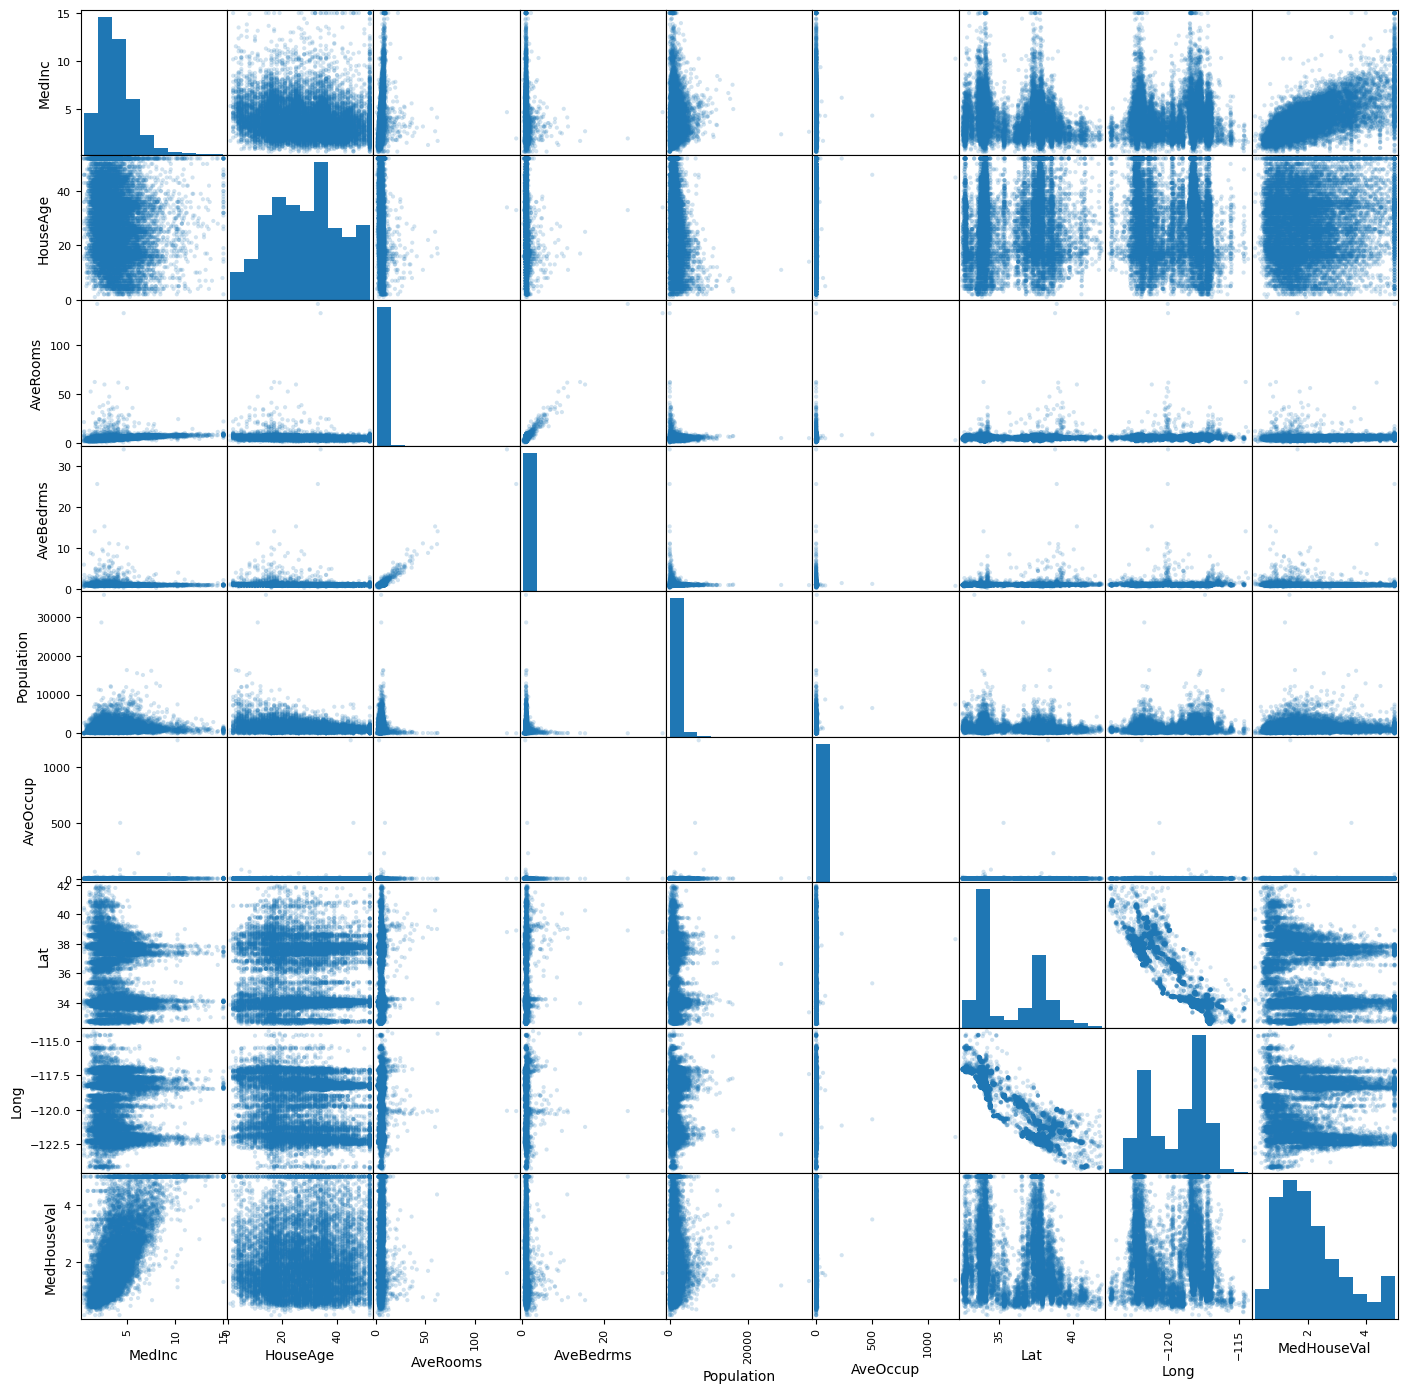

In [18]:
graph = pd.plotting.scatter_matrix(df, alpha=0.2, figsize=(17, 17), diagonal='hist')

In [34]:
profile_report = ProfileReport(df, title="Profiling Report")
profile_report

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

### Preprocessing

Here we will normalize data and split the train set into subtrain set and validation set.

In [6]:
scaler = StandardScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)

In [7]:
x_train_train, x_val, y_train_train, y_val = train_test_split(x_train, y_train, test_size=0.2, random_state=42)
print(x_train.shape)
print(x_val.shape)

(15480, 8)
(3096, 8)


## Task b
Design your neural network architecture for the regression task. Explain your choices for the output layer and the error function that you will use. Minimize the error by using mini-batches of suitable size. Test different architectures with varying numbers of hidden units and hidden layers. Compare these choices and report training and validation set errors in a table.

### Simplest example
We will build first the simplest NN model. This minimalistic style will be used in all next cells in the notebook. The output layes has only 1 neuron and the linear function will be used as activation because of the regression task. The Mean Absolute error was chosen to minimize the influence of outliers.

In [8]:
model = tf.keras.Sequential([
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(1)
])
model.compile(loss='mae', optimizer='adam', metrics=["mae", "mse"])
model.fit(
    x_train_train, y_train_train,
    validation_data=(x_val, y_val),
    epochs=100,
    batch_size=64,
    verbose=0
)
model.evaluate(x_test, y_test)

162/162 [==============================] - 0s 1ms/step - loss: 0.3600 - mae: 0.3600 - mse: 0.3000


[0.3600239157676697, 0.3600239157676697, 0.29997923970222473]

### Batches

The whole assignment contains tasks to tune some hyperparameters so we will use the `ray.tune` framework to run and summarize experiments. Let's look into the code. The first function builds, trains and evaluates a model with predefined parameters which are stored in `config` input parameter. At the end of the function's work the `ray.tune` framework will be notified about the metrics of the model with a callback. The tuning server is started with `ray.init` command and should be switched off after the training with `ray.shutdown`.

In [28]:
ray.init(ignore_reinit_error=True, log_to_driver=False, logging_level="ERROR")

RayContext(dashboard_url='127.0.0.1:8265', python_version='3.10.13', ray_version='2.8.0', ray_commit='105355bd253d6538ed34d331f6a4bdf0e38ace3a', protocol_version=None)

In [29]:
def train_batches(config):
    # https://github.com/tensorflow/tensorflow/issues/32159
    import tensorflow as tf
    epochs = 20
    
    model = tf.keras.Sequential([
        tf.keras.layers.Dense(64, activation='relu'),
        tf.keras.layers.Dense(64, activation='relu'),
        tf.keras.layers.Dense(1)
    ])
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=0.01),
        loss='mae', 
        metrics=['mae']
    )
    model.fit(
        x_train, y_train,
        validation_data=(x_test, y_test),
        epochs=epochs,
        batch_size=config["batches"],
        verbose=0,
        callbacks=[ReportCheckpointCallback(metrics={"MAE": "val_mae", "Loss": "loss"})]
    )

The next function defines the parameter of the tuner. For making the process faster we will train models distributed. The `resources` parameter defines the resources that can be taken by each train process. The `samples` parameter defines how many random models with same parameters will be run, in our case it will be 3. The `param_space` parameter defines the search space. Considering that fact that tuning can take some time(simetimes really long) the results will be first written to the disk as `.csv` file and then read from the disk in the next cell. In our case we will use `[8, 16, 32, 64, 128, 256]` sizes of batches.

In [32]:
def tune_batches():

    tuner = tune.Tuner(
        tune.with_resources(train_batches, resources={"cpu": 2, "gpu": 1}),
        tune_config=tune.TuneConfig(
            metric="MAE",
            mode="min",
            num_samples=3,
        ),
        run_config=train.RunConfig(
            local_dir="/ray",
        ),
        param_space={
            "batches": tune.grid_search([8, 16, 32, 64, 128, 256]),
        },
    )
    results = tuner.fit()
    df = results.get_dataframe(filter_metric="MAE", filter_mode="min")[["MAE", "Loss", "config/batches"]].sort_values(by=["MAE"])
    df.to_csv("batches.csv")

In [ ]:
tune_batches()

In [40]:
ray.shutdown()

In [48]:
pd.read_csv("batches.csv").groupby("config/batches").mean().sort_values(by=["MAE"])[["MAE", "Loss"]]

MAE      Loss
config/batches                    
256             0.337547  0.345829
64              0.344033  0.350798
32              0.344303  0.356113
128             0.346684  0.357151
16              0.350990  0.371699
8               0.357621  0.377743

Considering the table we will use the `256` size of bathces in all next trainings.

### Layers & units
We will tune models with `1-3` hidden layers and all possible options of asigning `[8, 16, 32, 64]` units per layer.

In [41]:
ray.init(ignore_reinit_error=True, log_to_driver=False, logging_level="ERROR")

RayContext(dashboard_url='127.0.0.1:8265', python_version='3.10.13', ray_version='2.8.0', ray_commit='105355bd253d6538ed34d331f6a4bdf0e38ace3a', protocol_version=None)

In [42]:
def train_architectures(config):
    # https://github.com/tensorflow/tensorflow/issues/32159
    import tensorflow as tf

    batch_size = 256
    epochs = 20
    
    scaler = tf.keras.layers.Normalization()
    scaler.adapt(x_train)

    hidden_layers = [
        tf.keras.layers.Dense(config["units"][index], activation='relu')
        for index, _ in enumerate(range(config["layers"]))
    ]
    
    model = tf.keras.Sequential([
        scaler,
        *hidden_layers,
        tf.keras.layers.Dense(1)
    ])
    model.compile(
        optimizer=tf.keras.optimizers.SGD(learning_rate=0.01),
        loss='mae', 
        metrics=['mae']
    )
    model.fit(
        x_train, y_train,
        validation_data=(x_test, y_test),
        epochs=epochs,
        batch_size=batch_size,
        verbose=0,
        callbacks=[ReportCheckpointCallback(metrics={"MAE": "val_mae", "Loss": "loss"})]
    )

In [43]:
def tune_architectures():

    tuner = tune.Tuner(
        tune.with_resources(train_architectures, resources={"cpu": 2, "gpu": 1}),
        tune_config=tune.TuneConfig(
            metric="MAE",
            mode="min",
            num_samples=3,
        ),
        run_config=train.RunConfig(
            local_dir="/ray",
        ),
        param_space={
            "layers": tune.grid_search([1, 2, 3]),
            "units": tune.grid_search(list(product([2 ** i for i in range(3, 7)], repeat=3))),
        },
    )
    results = tuner.fit()
    df = results.get_dataframe(filter_metric="MAE", filter_mode="min")[["MAE", "Loss", "config/layers", "config/units"]].sort_values(by=["MAE"])
    df.to_csv("architectures.csv")

In [8]:
tune_architectures()

Finished training.


In [9]:
ray.shutdown()

In [44]:
pd.read_csv("architectures.csv").groupby(["config/layers", "config/units"]).mean().sort_values(by=["MAE"])

Unnamed: 0       MAE      Loss
config/layers config/units                                
3             (64, 16, 8)        350.0  0.449733  0.453553
              (64, 32, 16)       173.0  0.453220  0.461438
              (64, 16, 16)       161.0  0.453817  0.458119
              (64, 64, 32)       380.0  0.454656  0.461929
2             (32, 16, 16)       112.0  0.454797  0.462145
3             (64, 64, 8)        566.0  0.455422  0.463613
              (64, 8, 32)        152.0  0.456252  0.465094
              (64, 32, 64)       563.0  0.456668  0.464424

## Optimizers

In [5]:
ray.init(ignore_reinit_error=True, log_to_driver=False, logging_level="ERROR")

RayContext(dashboard_url='127.0.0.1:8265', python_version='3.10.13', ray_version='2.8.0', ray_commit='105355bd253d6538ed34d331f6a4bdf0e38ace3a', protocol_version=None)

In [7]:
def train_optimizers(config):
    import tensorflow as tf

    batch_size = 256
    epochs = 100
    
    scaler = tf.keras.layers.Normalization()
    scaler.adapt(x_train)
    
    model = tf.keras.Sequential([
        scaler,
        tf.keras.layers.Dense(128, activation='relu'),
        tf.keras.layers.Dense(128, activation='relu'),
        tf.keras.layers.Dense(128, activation='relu'),
        tf.keras.layers.Dense(1)
    ])
    model.compile(
        optimizer=config["optimizers"](learning_rate=config["rates"], ),
        loss='mae', 
        metrics=['mae']
    )
    model.fit(
        x_train, y_train,
        validation_data=(x_test, y_test),
        epochs=epochs,
        batch_size=batch_size,
        verbose=0,
        callbacks=[ReportCheckpointCallback(metrics={"MAE": "val_mae", "Loss": "loss"})]
    )

In [8]:
def tune_optimizers():

    tuner = tune.Tuner(
        tune.with_resources(train_optimizers, resources={"cpu": 2, "gpu": 1}),
        tune_config=tune.TuneConfig(
            metric="MAE",
            mode="min",
            num_samples=3,
        ),
        run_config=train.RunConfig(
            local_dir="/ray",
        ),
        param_space={
            "optimizers": tune.grid_search([
                tf.keras.optimizers.Adam,
                tf.keras.optimizers.SGD
            ]),
            "rates": tune.grid_search(np.linspace(0.01, 0.1, 10)),
        },
    )
    results = tuner.fit()
    df = results.get_dataframe(filter_metric="MAE", filter_mode="min")[["MAE", "Loss", "config/optimizers", "config/rates"]].sort_values(by=["MAE", "Loss"]).iloc[:10]
    df.to_csv("optimizers.csv")

    print("Finished training.")

In [9]:
tune_optimizers()

Finished training.


In [12]:
ray.shutdown()

In [10]:
df = pd.read_csv("optimizers.csv")
df

Unnamed: 0       MAE      Loss                         config/optimizers  \
0           0  0.320586  0.286947  <class 'keras.src.optimizers.adam.Adam'>   
1          40  0.325038  0.306099  <class 'keras.src.optimizers.adam.Adam'>   
2          42  0.326178  0.310734  <class 'keras.src.optimizers.adam.Adam'>   
3          20  0.326243  0.303846  <class 'keras.src.optimizers.adam.Adam'>   
4           2  0.327706  0.314766  <class 'keras.src.optimizers.adam.Adam'>   
5          22  0.328111  0.330297  <class 'keras.src.optimizers.adam.Adam'>   
6          44  0.332566  0.328755  <class 'keras.src.optimizers.adam.Adam'>   
7          24  0.332684  0.329418  <class 'keras.src.optimizers.adam.Adam'>   
8          39  0.337166  0.346180    <class 'keras.src.optimizers.sgd.SGD'>   
9           4  0.337931  0.335772  <class 'keras.src.optimizers.adam.Adam'>   

   config/rates  
0          0.01  
1          0.01  
2          0.02  
3          0.01  
4          0.02  
5          0.02  
6          0.03  
7          0.03  
8          0.10  
9          0.03

## Task C
Now assume that we want to use a similar architecture for the binary
classification problem of determining if the median house value is below or over
$200, 000. Explain which parts of the architecture and the training pipeline
you would need to change, and which test set evaluation metrics should be
investigated in this case. Explain the reasons for these differences.
Implement these changes to the architecture and the training pipeline you had
in part (d), and train a single model for this binary classification task using
the whole training set. Note that you will also need to redefine your target
variables by simply executing the following lines in the order:
```python
y_train[y_train<2], y_test[y_test<2] = 0, 0
y_train[y_train>=2], y_test[y_test>=2] = 1, 1
```
Evaluate your model on the test set, report and comment on its performance.

In [77]:
y_train_class = np.array(y_train, copy=True)
y_test_class = np.array(y_test, copy=True)
y_train_class[y_train_class < 2], y_test_class[y_test_class < 2] = 0, 0
y_train_class[y_train_class >= 2], y_test_class[y_test_class >= 2] = 1, 1

In [73]:
scaler = tf.keras.layers.Normalization()
scaler.adapt(x_train)
model = tf.keras.Sequential([
    scaler,
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(2, activation='softmax')
])
model.compile(
    loss="sparse_categorical_crossentropy",
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.01),
    metrics=["accuracy"]
)
model.fit(
    x_train, y_train_class,
    validation_data=(x_test, y_test_class),
    epochs=100,
    batch_size=256
)

Epoch 1/100
61/61 [==============================] - 2s 7ms/step - loss: 0.4110 - accuracy: 0.8204 - val_loss: 0.3189 - val_accuracy: 0.8572
Epoch 2/100
61/61 [==============================] - 0s 4ms/step - loss: 0.3288 - accuracy: 0.8519 - val_loss: 0.3143 - val_accuracy: 0.8597
Epoch 3/100
61/61 [==============================] - 0s 5ms/step - loss: 0.3173 - accuracy: 0.8578 - val_loss: 0.3139 - val_accuracy: 0.8589
Epoch 4/100
61/61 [==============================] - 0s 4ms/step - loss: 0.3087 - accuracy: 0.8631 - val_loss: 0.3068 - val_accuracy: 0.8688
Epoch 5/100
61/61 [==============================] - 0s 5ms/step - loss: 0.3091 - accuracy: 0.8640 - val_loss: 0.3160 - val_accuracy: 0.8620
Epoch 6/100
61/61 [==============================] - 0s 4ms/step - loss: 0.3071 - accuracy: 0.8654 - val_loss: 0.2944 - val_accuracy: 0.8698
Epoch 7/100
61/61 [==============================] - 0s 4ms/step - loss: 0.2910 - accuracy: 0.8694 - val_loss: 0.2897 - val_accuracy: 0.8723
Epoch 8/100
6

In [32]:
model.evaluate(x_test, y_test_class)

162/162 [==============================] - 0s 2ms/step - loss: 0.5188 - accuracy: 0.8609


[0.5188437104225159, 0.8608527183532715]

In [43]:
x = np.array([0, 5])
x_onehot = np.identity(6)[x]